In [1]:
#Web scraping imports 
from bs4 import BeautifulSoup
import requests
import pandas as pd
import html2text #For extracting texts  

#Data vis and modelling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import make_regression 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np

In [ ]:
#sample url
url = "https://weather.com/weather/tenday/l/9649a410203fa0d4c1082bc29eb8ab42e886f153fc186ac35b3e440253c85fea"
#request the page
page = requests.get(url)
#creating a soup object and the parser
soup = BeautifulSoup(page.content, 'lxml') 

#h3 DailyContent--daypartName--1bzYn Date

#span DailyContent--temp--3d4dn Temperature 
#Output: 90°

#span DailyContent--value--37sk2 Rain chance, Wind 
#Output: 20% / W 9 mph

#span DetailsTable--value--1q_qD Humidity, UV Index, Sunrise and set.
#Output: 73% / 5 of 10 / 5:38 am / 6:26 pm


#Locate parent_div where you can see all the data
parent_section = soup.find('body')
 

#Used dictionary for easy parsing
#Key = Date; Values = {temparature, rain_chance, wind, humidity, uv, sunrise, sunset}
row = {}

#Loop through days 
ctr = 0
for div in parent_section('div', class_= 'DaypartDetails--Content--hJ52O DaypartDetails--contentGrid--1SWty'):  
     for child_div in div('div', class_='DailyContent--DailyContent--KcPxD'):    
        #Date 
        date = child_div.find('h3')
        date = html2text.html2text(str(date)) #Output: ### Wed 27 | Day  
        date = date[3:].strip()  
        row[date] = {'temperature':'','rain_chance':'','wind':'','humidity':'','uv':'','sunrise':'','sunset':''} 
    
        #Temperature
        temp_data = child_div.find('span', class_='DailyContent--temp--3d4dn')
        temperature =  html2text.html2text((str(temp_data))) #Output: 90°
        temperature = temperature.strip()[:-1]
        row[date]['temperature'] = temperature 
            
        #Rain chance and wind
        for temp_data in child_div('span', class_='DailyContent--value--37sk2'):
            rc_wind =  html2text.html2text((str(temp_data))) #Output: 20% / W 9 mph
            rc_wind = rc_wind.strip() 
            #If 0 = rc, 1 = wind
            if ctr == 0:
                row[date]['rain_chance'] = rc_wind
                ctr = 1
            elif ctr == 1:
                row[date]['wind'] = rc_wind
                ctr = 0   
        
        #Description
        temp_data = child_div.find('p', class_='DailyContent--narrative--hplRl')
        narrative =  html2text.html2text((str(temp_data)))
        narrative = narrative.strip()
        row[date]['narrative'] = narrative 
        
        #Humidity, UV Index, Sunrise and set.
        temp_div = child_div.find_next_sibling('div')
        for temp_data in temp_div('span', class_='DetailsTable--value--1q_qD'):
            hum_uv_rise_set =  html2text.html2text((str(temp_data))) #Output: 73% / 5 of 10 / 5:38 am / 6:26 pm
            hum_uv_rise_set = hum_uv_rise_set.strip() 
            #If 0 = rc, 1 = wind
            if ctr == 0:
                row[date]['humidity'] = hum_uv_rise_set
                ctr = 1
            elif ctr == 1:
                row[date]['uv'] = hum_uv_rise_set
                ctr = 2
            elif ctr == 2:
                row[date]['sunrise'] = hum_uv_rise_set
                ctr = 3
            elif ctr == 3:
                row[date]['sunset'] = hum_uv_rise_set
                ctr = 0
        row[date]['moon'] = html2text.html2text(str(temp_div.find('span', class_='DetailsTable--moonPhrase--2WlTc'))).strip()

In [ ]:
#Append dict to df
df = pd.DataFrame.from_dict(row,orient='index') 

#Dataframe fixes
df = df.reset_index() 
df = df.rename(columns={'index':'date'})

df

df.to_csv('10dayforecast_manila.csv', index = None)

Data Cleansing

In [ ]:
missing_values = ["\--", "None"]
df = pd.read_csv("10dayforecast_manila.csv", na_values = missing_values)
df.head(8)


In [ ]:
#Day Date not parsable, use datetime now and increment by 12 hours (Day/night) instead.

from datetime import datetime, timedelta
 
now = datetime.now()

if now < now.replace(hour=18, minute=0, second=0, microsecond = 0):
    now = now.replace(hour=18, minute=0, second=0, microsecond = 0)
else:
    now = now.replace(hour=6, minute=0, second=0, microsecond = 0)

for i, row in df.iterrows(): 
    df.at[i,'date'] = now.strftime("%d/%m/%Y %H:00:00")
    now = now + timedelta(hours=12)  

In [ ]:
dfrename = df.rename(columns={"rain_chance":"precipitation"}, inplace=True)
df['precipitation'] = df['precipitation'].str.rstrip('%').astype('int')

In [ ]:
df['wind'] = df['wind'].map(lambda x: x.lstrip('+-').rstrip('mph'))
df[['wind_direction', 'wind']] = df['wind'].str.split(' ', 1, expand=True)
sixth_column = df.pop('wind_direction')
df.insert(5, 'wind_direction', sixth_column) 
df['humidity'] = df['humidity'].str.rstrip('%').astype('int')
df['uv'] = df['uv'].str.split(' ').str[0]
for i, row in df.iterrows():
  if len(row['uv']) > 3:
    df.at[i,'uv'] = str(10)
df['sunset']
df['sunset'].isnull()
df["sunset"].fillna("N/A", inplace = True)
df['moon']
df['moon'].isnull()
df["moon"].fillna("N/A", inplace = True)

In [ ]:
df.to_csv('10dayforecast_manila_cleansed.csv', index = None)
df

In [2]:
#Load csv
df = pd.read_csv('10dayforecast_manila_cleansed.csv')
df = df.sample(frac=1) #Randomized index because precipitation plateau at day 6
df.head()

,date,temperature,precipitation,wind,humidity,wind_direction,uv,sunrise,sunset,narrative,moon
8,01/08/2022 18:00:00,79,78,7,88,SW,0,8:21 am,8:59 pm,Thunderstorms likely in the evening. Then a ch...,Waxing Crescent
15,05/08/2022 06:00:00,87,60,7,79,WSW,9,5:40 am,6:23 pm,Thunderstorms. High 87F. Winds WSW at 5 to 10 ...,NaN
17,06/08/2022 06:00:00,88,60,9,78,SSW,6,5:40 am,6:23 pm,Thunderstorms. High 88F. Winds SSW at 5 to 10 ...,NaN
7,01/08/2022 06:00:00,87,96,12,79,WSW,6,5:39 am,6:25 pm,Thunderstorms. High 87F. Winds WSW at 10 to 15...,NaN
24,09/08/2022 18:00:00,79,60,7,87,SSW,0,3:52 pm,2:15 am,Thunderstorms. Low 79F. Winds SSW at 5 to 10 m...,Waxing Gibbous


In [3]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [4]:
x = np.array(df[['temperature','precipitation','wind','uv']]) #Columns with real numbers
y = np.array(df['humidity']) #Data to be used

x = StandardScaler().fit_transform(x)  #Standardization
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1) #Split data into train and test
x_train_fs, x_test_fs, fs = select_features(x_train, y_train, x_test)

Feature 0: 1232.051711
Feature 1: 0.037784
Feature 2: 8.452030
Feature 3: 134.466330


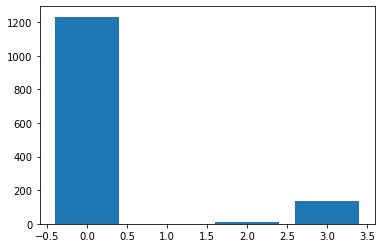

In [5]:
# Scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [6]:
x = np.array(df[['temperature','wind','uv']]) #Feature selection
y = np.array(df['humidity'])  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1) #Split data into train and test
x_train_fs, x_test_fs, fs = select_features(x_train, y_train, x_test)

In [7]:
model = LinearRegression().fit(x_train, y_train) #Fit train data into linear regression model.
predictions = model.predict(x_test) 

In [8]:
print("Predictions: \n")

for i in range(len(predictions)): 
  print('PREDICTED HUMIDITY : '+str(predictions[i])  ,'\t','ACTUAL HUMIDITY : '+str(y_test[i]))

print("\nR-squared value: ", model.score(x_test, y_test)) #Print accumulated data

Predictions: 

PREDICTED HUMIDITY : 88.53053720315155 	 ACTUAL HUMIDITY : 89
PREDICTED HUMIDITY : 76.46558417410705 	 ACTUAL HUMIDITY : 76
PREDICTED HUMIDITY : 76.55494541776866 	 ACTUAL HUMIDITY : 78
PREDICTED HUMIDITY : 88.53053720315155 	 ACTUAL HUMIDITY : 88
PREDICTED HUMIDITY : 86.78177186330288 	 ACTUAL HUMIDITY : 86
PREDICTED HUMIDITY : 87.29304454507857 	 ACTUAL HUMIDITY : 88
PREDICTED HUMIDITY : 79.3930407220633 	 ACTUAL HUMIDITY : 79
PREDICTED HUMIDITY : 78.97396179070033 	 ACTUAL HUMIDITY : 79
PREDICTED HUMIDITY : 87.65615453322722 	 ACTUAL HUMIDITY : 89

R-squared value:  0.9749005484954103
